In [2]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from netlib import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
text = ""
ddir = "data/books/witcher_rus/"
for fn in sorted(os.listdir(ddir)):
    if fn.endswith(".gz"):
        with gzip.open(ddir + fn, "rb") as f:
            text += f.read().decode("utf-8").replace("\r", "")
charset = sorted(set(text))
print(charset)
print("%s chars, %s unique" % (len(text), len(charset)))
chidx = {ch: i for i, ch in enumerate(charset)}

raw_data = [chidx[ch] for ch in text]
data = np.array(raw_data, dtype=np.uint8)
dvec = np.eye(len(charset), dtype=np.float64)

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
5088376 chars, 140 unique


In [4]:
batch_size = 200

blen = len(data)//batch_size
print("%s chars in sequence" % blen)
bseqdata = data[:blen*batch_size].reshape(batch_size, blen).transpose()
#print(''.join([charset[k] for k in bseqdata.transpose()[-1]]))

25441 chars in sequence


In [5]:
class Solver:
    def __init__(self, net, optims, **params):
        self.params = params
        self.name = params["name"]
        self.net = net
        
        if isinstance(optims, Optim):
            optims = [optims]
        self.optims = optims
        
        self.loss_history = []
        
    def learn(self, inseq, outseq):
        if inseq.shape[0] != outseq.shape[0]:
            mlen = min((inseq.shape[0], outseq.shape[0]))
            inseq = inseq[0:mlen]
            outseq = outseq[0:mlen]
        seqlen = inseq.shape[0]
        
        loss = 0.0
        cache = []
        
        h = self.net.newstate(inseq.shape[1])
        if isinstance(h, np.ndarray):
            h = (h,)
        for x, ir in zip(dvec[inseq], outseq):
            ovs, m = self.net.forward((x, *h))
            y, h = ovs[0], ovs[1:]
            smy = softmax(y)
            cache.append((m, smy, ir))
            loss += ce_loss(smy, ir)
        loss /= len(cache)

        grad = self.net.newgrad()
        dh = self.net.newstate(inseq.shape[1])
        if isinstance(dh, np.ndarray):
            dh = (dh,)
        for m, smy, ir in reversed(cache):
            ovs = self.net.backward(grad, m, (ce_softmax_deriv(smy, ir), *dh))
            dh = ovs[1:]

        modgrad(grad, norm=1, clip=5)
        for optim in self.optims:
            optim.learn(self.net, grad)

        self.loss_history.append(loss)
            
    def sample(self, seed, textlen):
        h = self.net.newstate(1)
        if isinstance(h, np.ndarray):
            h = (h,)
        text = ""
        c = seed
        x = dvec[c].reshape(1, -1)
        text += charset[c]
        for i in range(textlen):
            ovs, _ = self.net.forward((x, *h))
            y, h = ovs[0], ovs[1:]
            smy = softmax(y)
            c = np.random.choice(np.arange(len(charset)), p=smy.reshape(-1))
            text += charset[c]
            x = dvec[c].reshape(1, -1)
        return text

In [54]:
def plot_solvers(sols, red=10, win=100):
    if isinstance(sols, Solver):
        sols = [sols]
        
    plt.subplot(2, 1, 1)
    for sol in sols:
        plt.plot(sol.loss_history[::red], label=sol.name)
    plt.legend()

    plt.subplot(2, 1, 2)
    for sol in sols:
        plt.plot(
            sol.loss_history[-win:], 
            label="%s loss: %.4f" % (sol.name, sol.loss_history[-1])
        )
    plt.legend()
    
    plt.show()

In [55]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [59]:
def run_solvers(solvers, seqlen, pos=0, plot=True):
    stop_on_signal()
    while not signal_done:
        for i, sol in enumerate(solvers):
            if len(sol.loss_history) == 0 or not np.isnan(sol.loss_history[-1]):
                sol.learn(bseqdata[pos:pos+seqlen], bseqdata[pos+1:pos+seqlen+1])
        if plot:
            clear_output(wait=True)
            plot_solvers(solvers)
        
        pos += seqlen
        if pos >= bseqdata.shape[0] - 1:
            pos = 0
    return pos

In [60]:
class LSTMxN(Net):
    def __init__(self, sizes):
        self.sizes = sizes
        nets = [LSTM(sxhy) for sxhy in zip([sizes[0]] + sizes[2:-1], sizes[1:-1], sizes[2:])]
        ln = len(nets)
        links = [((-1, 0), (0, 0)), ((ln-1, 0), (-1, 0))] # input and output
        links += [((i, 0), (i+1, 0)) for i in range(ln-1)] # connections between LSTMs
        links += [((-1, 1+2*i+j), (i, 1+j)) for i in range(ln) for j in range(2)] # memory inputs
        links += [((i, 1+j), (-1, 1+2*i+j)) for i in range(ln) for j in range(2)] # memory outputs
        super().__init__(nets, links)
    
    def newstate(self, count):
        return [s for n in self.nodes for s in n.newstate(count)]

In [70]:
seqlen = 100
hidden_size = 20
learn_rates = [2e-2, 1e-2, 5e-3]

solvers = [
    Solver(
        LSTMxN([len(charset)] + [hidden_size]*(i+1) + [len(charset)]),
        Adam(lr), name=("LSTMx%s lr: %s" % (i+1, lr))
    ) for i, lr in enumerate(learn_rates)
]
pos = 0

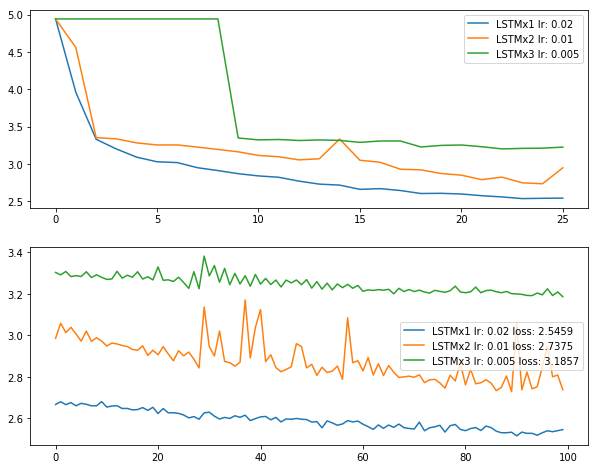

In [71]:
pos = run_solvers(solvers, seqlen, pos)

In [ ]:
for sol in solvers:
    print("[%s]" % sol.name)
    print(sol.sample(data[pos], 1000))